## Explore Data and process for further modeling
### Outline
   
- **Preliminary data exploration** 
- **Data Cleaning/Processing**
    - Identify unique advertisements and corresponding advertisements
    - Filter out data i.e.<24 hours
    - Interpolate missing data
- **Feature Engineering**
    - Define and identify KPIs
    - Save Prepared Data

## Data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os 

from datetime import timedelta

from scripts.preprocess import extract_hour_from_time_string
from scripts.preprocess import combine_two_ids_to_one_unique_id
from scripts.preprocess import extract_start_end_hour_per_id
from scripts.preprocess import get_ads_lasting_n_hours
from scripts.preprocess import extract_and_interpolate_valid_ads
from scripts.preprocess import get_ctr, get_conversion_rate, get_custom_conversion_rate
from scripts.preprocess import get_prepared_data_summary
from scripts.utils import extract_date_features
from scripts.utils import create_directory

In [3]:
sns.__version__

'0.11.1'

In [12]:
df = pd.read_csv(r"data/2105 Data Science Campaign Optimization facebook_ad_hourly_v01.csv", sep=';')
print('Unique campaigns found :{}, Unique advertisements found:{}'.format(df.campaign_id.nunique(), df.ad_id.nunique()))
df.info()

Unique campaigns found :33, Unique advertisements found:1061
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54314 entries, 0 to 54313
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   54314 non-null  int64  
 1   campaign_id  54314 non-null  int64  
 2   ad_id        54314 non-null  int64  
 3   date         54314 non-null  object 
 4   time         54314 non-null  object 
 5   spend        54314 non-null  float64
 6   reach        0 non-null      float64
 7   impressions  54314 non-null  int64  
 8   clicks       54314 non-null  int64  
 9   purchase     388 non-null    float64
dtypes: float64(3), int64(5), object(2)
memory usage: 4.1+ MB


Dropping unnecessary Unnamed: 0 column and replace nan values of purchase column

In [13]:
df = df.drop(["Unnamed: 0", 'reach'],axis=1)
df['purchase'] = df['purchase'].fillna(0)
df.head()

,campaign_id,ad_id,date,time,spend,impressions,clicks,purchase
0,23843490210650549,23843490222550549,2019-07-18,07:00:00 - 07:59:59,0.04,6,0,0.0
1,23843490210650549,23843490222600549,2019-07-18,07:00:00 - 07:59:59,0.00,2,0,0.0
2,23843490210650549,23843490222650549,2019-07-18,07:00:00 - 07:59:59,0.00,1,0,0.0
3,23843490210650549,23843490222880549,2019-07-18,07:00:00 - 07:59:59,0.04,5,0,0.0
4,23843490224560549,23843490225720549,2019-07-18,07:00:00 - 07:59:59,0.01,1,0,0.0


Convert date columns to appropuate format and add hour to date column

In [14]:
df['date'] = pd.to_datetime(df['date'])
df['hour'] = extract_hour_from_time_string (df,'time', '_', '%H:%M:%S')
df['datetime'] = df['date']
df['datetime']+=  pd.to_timedelta(df['hour'], unit='h')

## Preliminary data exploration

See how ads are distributed in campaign

In [15]:
save_folder = r"plots/preliminary_EDA"
create_directory(save_folder)

In [16]:
ads_per_campapign = df.groupby('campaign_id')['ad_id'].nunique().to_frame().reset_index()
ads_per_campapign.columns = ['campaign_id', 'ad_count']
# create custom campaign index for better visibility
unique_campaigns = list(ads_per_campapign['campaign_id'].unique())
ads_per_campapign ['campaign_id'] = ads_per_campapign['campaign_id'].apply(lambda x: unique_campaigns.index(x))

In [17]:
ads_per_campapign.ad_count.describe()

count     33.000000
mean      32.151515
std       65.390711
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max      234.000000
Name: ad_count, dtype: float64

Plot the result in bar plot

Text(0.5, 1.0, 'Ads per campaign')

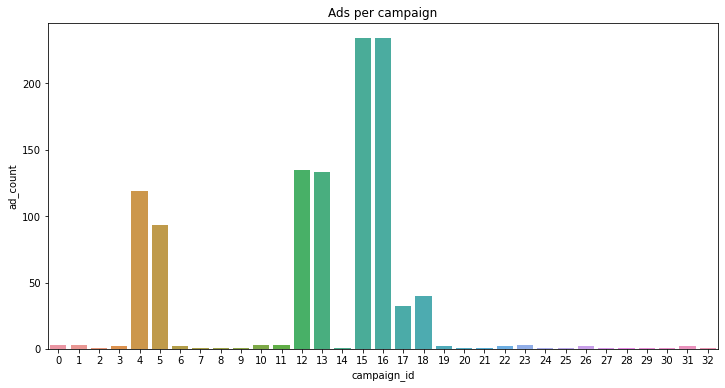

In [18]:
plt.figure(figsize=(12,6))
sns.barplot(y='ad_count', x='campaign_id', data=ads_per_campapign)
plt.savefig( f"{save_folder}{os.sep}"+'ads_per_campaign_prior_processing.jpg', dpi=300, bbox_inches = "tight")
plt.title('Ads per campaign')

**Pair-wise linear relationship: crude initial observation**

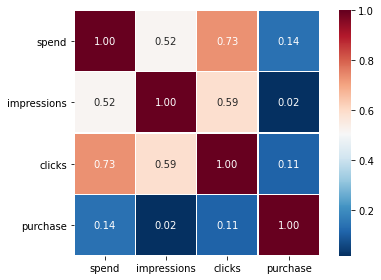

In [19]:
sns.heatmap(df[['spend','impressions','clicks','purchase']]._get_numeric_data().astype(float).corr(),
            square=True, 
            cmap='RdBu_r', 
            linewidths=.5,
            annot=True, 
            fmt='.2f').figure.tight_layout()
plt.savefig( f"{save_folder}{os.sep}"+'correlation_prior_pre_processing.jpg', dpi=300, bbox_inches = "tight")
plt.show()

## Start Data Processing
Extract and gather valid advertisements

Combine campaign and id to get unique series or ids

In [20]:
df['unique_ids'] = combine_two_ids_to_one_unique_id(df, 
                                                    'campaign_id', 
                                                    'ad_id',
                                                    prefix1='campaign_id',
                                                    prefix2='ad_id')
df_raw = df.copy()
df.drop(['ad_id', 'date', 'time'], axis=1, inplace=True)
print('There are {} unique series found in the given data set.'.format(df_raw.unique_ids.nunique()))

There are 1061 unique series found in the given data set.


#### Extract first hour, last hour, endtime and total duration for each unique advertisement

In [21]:
unique_campaign_advertisement_info = extract_start_end_hour_per_id(df,
                                                                   'unique_ids',
                                                                   'datetime',
                                                                   'first_hour',
                                                                   'endtime')

#extract 24th hour(i.e. last hour and duration in hours)
unique_campaign_advertisement_info['last_hour'] = unique_campaign_advertisement_info['first_hour']+ timedelta(hours=23)
unique_campaign_advertisement_info

,first_hour,endtime,last_hour
unique_ids,,,
campaign_id_23843427462090549_ad_id23843429354180549,2019-06-21 12:00:00,2019-06-23 23:00:00,2019-06-22 11:00:00
campaign_id_23843427462090549_ad_id23843429359190549,2019-06-21 12:00:00,2019-06-23 23:00:00,2019-06-22 11:00:00
campaign_id_23843427462090549_ad_id23843429359200549,2019-06-21 13:00:00,2019-06-23 12:00:00,2019-06-22 12:00:00
campaign_id_23843429400540549_ad_id23843429400560549,2019-06-21 12:00:00,2019-06-23 12:00:00,2019-06-22 11:00:00
campaign_id_23843429400540549_ad_id23843429400570549,2019-06-21 12:00:00,2019-06-23 22:00:00,2019-06-22 11:00:00
...,...,...,...
campaign_id_23845347387450549_ad_id23845347387470549,2020-08-28 16:00:00,2020-09-04 00:00:00,2020-08-29 15:00:00
campaign_id_23845373948350549_ad_id23845373948370549,2020-08-31 13:00:00,2020-09-06 12:00:00,2020-09-01 12:00:00
campaign_id_23845467764400549_ad_id23845467764450549,2020-09-09 02:00:00,2020-09-14 00:00:00,2020-09-10 01:00:00


Let's check how all the advertisements lifetime looks like

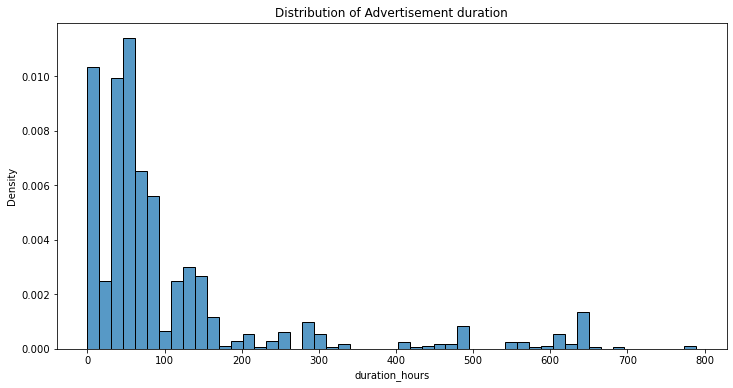

In [22]:
unique_campaign_advertisement_info['duration_hours']=(unique_campaign_advertisement_info['endtime']-unique_campaign_advertisement_info['first_hour']).astype('timedelta64[h]')

plt.figure(figsize=(12,6))
sns.histplot(data=unique_campaign_advertisement_info, x="duration_hours", stat="density")
plt.savefig( f"{save_folder}{os.sep}"+'ads_by_duration_desityplot.jpg', dpi=300, bbox_inches = "tight")
plt.title('Distribution of Advertisement duration')

unique_campaign_advertisement_info = unique_campaign_advertisement_info.drop(['duration_hours'],axis=1)

#### Extract campaign advertisements that lasts at least 25 hours

In [23]:
index = get_ads_lasting_n_hours(unique_campaign_advertisement_info, 'first_hour', 'endtime', 25)
unique_campaign_advertisement_info = unique_campaign_advertisement_info.loc[index]
unique_campaign_advertisement_info

,first_hour,endtime,last_hour,duration_hours
unique_ids,,,,
campaign_id_23843427462090549_ad_id23843429354180549,2019-06-21 12:00:00,2019-06-23 23:00:00,2019-06-22 11:00:00,59.0
campaign_id_23843427462090549_ad_id23843429359190549,2019-06-21 12:00:00,2019-06-23 23:00:00,2019-06-22 11:00:00,59.0
campaign_id_23843427462090549_ad_id23843429359200549,2019-06-21 13:00:00,2019-06-23 12:00:00,2019-06-22 12:00:00,47.0
campaign_id_23843429400540549_ad_id23843429400560549,2019-06-21 12:00:00,2019-06-23 12:00:00,2019-06-22 11:00:00,48.0
campaign_id_23843429400540549_ad_id23843429400570549,2019-06-21 12:00:00,2019-06-23 22:00:00,2019-06-22 11:00:00,58.0
...,...,...,...,...
campaign_id_23845345434590549_ad_id23845345434720549,2020-08-28 16:00:00,2020-09-04 12:00:00,2020-08-29 15:00:00,164.0
campaign_id_23845347387450549_ad_id23845347387470549,2020-08-28 16:00:00,2020-09-04 00:00:00,2020-08-29 15:00:00,152.0
campaign_id_23845373948350549_ad_id23845373948370549,2020-08-31 13:00:00,2020-09-06 12:00:00,2020-09-01 12:00:00,143.0


#### Put all valid series together in a dataframe

In [24]:
%%time
prepared_df, __ = extract_and_interpolate_valid_ads(df, 
                                                    unique_campaign_advertisement_info,
                                                    'datetime', 
                                                    'first_24_hour', 
                                                    'test_set',
                                                    'unique_ids',
                                                     3)

1. Valid Ids campaign_id_23843427462090549_ad_id23843429354180549: duration in hours 59
2. Valid Ids campaign_id_23843427462090549_ad_id23843429359190549: duration in hours 60
3. Valid Ids campaign_id_23843427462090549_ad_id23843429359200549: duration in hours 23
4. Valid Ids campaign_id_23843429400540549_ad_id23843429400560549: duration in hours 11
5. Valid Ids campaign_id_23843429400540549_ad_id23843429400570549: duration in hours 59
6. Valid Ids campaign_id_23843429400540549_ad_id23843429400590549: duration in hours 40
7. Valid Ids campaign_id_23843437921360549_ad_id23843437921420549: duration in hours 252
8. Valid Ids campaign_id_23843437921380549_ad_id23843437921400549: duration in hours 236
9. Valid Ids campaign_id_23843437921380549_ad_id23843437921450549: duration in hours 226
10. Valid Ids campaign_id_23843490210650549_ad_id23843490212110549: duration in hours 32
11. Valid Ids campaign_id_23843490210650549_ad_id23843490212120549: duration in hours 312
12. Valid Ids campaign_id_

114. Valid Ids campaign_id_23843490210650549_ad_id23843504283350549: duration in hours 111
115. Valid Ids campaign_id_23843490210650549_ad_id23843504283360549: duration in hours 103
116. Valid Ids campaign_id_23843490210650549_ad_id23843504283370549: duration in hours 129
117. Valid Ids campaign_id_23843490210650549_ad_id23843504283380549: duration in hours 103
118. Valid Ids campaign_id_23843490210650549_ad_id23843504283390549: duration in hours 130
119. Valid Ids campaign_id_23843490210650549_ad_id23843504283400549: duration in hours 96
120. Valid Ids campaign_id_23843490210650549_ad_id23843504283410549: duration in hours 127
121. Valid Ids campaign_id_23843490210650549_ad_id23843504283420549: duration in hours 112
122. Valid Ids campaign_id_23843490210650549_ad_id23843504283430549: duration in hours 124
123. Valid Ids campaign_id_23843490210650549_ad_id23843504283440549: duration in hours 128
124. Valid Ids campaign_id_23843490210650549_ad_id23843504283450549: duration in hours 376


207. Valid Ids campaign_id_23843490224560549_ad_id23843490238510549: duration in hours 203
208. Valid Ids campaign_id_23843490224560549_ad_id23843504291900549: duration in hours 64
209. Valid Ids campaign_id_23843490224560549_ad_id23843504291930549: duration in hours 74
210. Valid Ids campaign_id_23843490224560549_ad_id23843504291970549: duration in hours 81
211. Valid Ids campaign_id_23843490224560549_ad_id23843504292000549: duration in hours 80
212. Valid Ids campaign_id_23843490224560549_ad_id23843504292020549: duration in hours 76
213. Valid Ids campaign_id_23843490224560549_ad_id23843504292030549: duration in hours 77
214. Valid Ids campaign_id_23843490224560549_ad_id23843504292050549: duration in hours 69
215. Valid Ids campaign_id_23843490224560549_ad_id23843504292060549: duration in hours 79
216. Valid Ids campaign_id_23843490224560549_ad_id23843504292080549: duration in hours 79
217. Valid Ids campaign_id_23843490224560549_ad_id23843504292100549: duration in hours 62
218. Vali

302. Valid Ids campaign_id_23843769769110549_ad_id23843769806490549: duration in hours 38
303. Valid Ids campaign_id_23843769769110549_ad_id23843769806500549: duration in hours 14
304. Valid Ids campaign_id_23843769769110549_ad_id23843769806510549: duration in hours 170
305. Valid Ids campaign_id_23843769769110549_ad_id23843769806870549: duration in hours 20
306. Valid Ids campaign_id_23843769769110549_ad_id23843769807980549: duration in hours 58
307. Valid Ids campaign_id_23843769769110549_ad_id23843769807990549: duration in hours 474
308. Valid Ids campaign_id_23843769769110549_ad_id23843769808200549: duration in hours 10
309. Valid Ids campaign_id_23843769769110549_ad_id23843769808380549: duration in hours 39
310. Valid Ids campaign_id_23843769769110549_ad_id23843769809390549: duration in hours 37
311. Valid Ids campaign_id_23843769769110549_ad_id23843769809400549: duration in hours 47
312. Valid Ids campaign_id_23843769769110549_ad_id23843769809420549: duration in hours 8
313. Vali

410. Valid Ids campaign_id_23843769822320549_ad_id23843769839040549: duration in hours 34
411. Valid Ids campaign_id_23843769822320549_ad_id23843769839270549: duration in hours 17
412. Valid Ids campaign_id_23843769822320549_ad_id23843769839280549: duration in hours 25
413. Valid Ids campaign_id_23843769822320549_ad_id23843769841490549: duration in hours 48
414. Valid Ids campaign_id_23843769822320549_ad_id23843769841560549: duration in hours 85
415. Valid Ids campaign_id_23843769822320549_ad_id23843769841630549: duration in hours 56
416. Valid Ids campaign_id_23843769822320549_ad_id23843769841680549: duration in hours 23
417. Valid Ids campaign_id_23843769822320549_ad_id23843769843330549: duration in hours 5
418. Valid Ids campaign_id_23843769822320549_ad_id23843769843400549: duration in hours 11
419. Valid Ids campaign_id_23843769822320549_ad_id23843769843460549: duration in hours 2
420. Valid Ids campaign_id_23843769822320549_ad_id23843769843470549: duration in hours 13
421. Valid I

513. Valid Ids campaign_id_23844530190320549_ad_id23844530208680549: duration in hours 14
514. Valid Ids campaign_id_23844530190320549_ad_id23844530209280549: duration in hours 40
515. Valid Ids campaign_id_23844530190320549_ad_id23844530209810549: duration in hours 19
516. Valid Ids campaign_id_23844530190320549_ad_id23844530210290549: duration in hours 28
517. Valid Ids campaign_id_23844530190320549_ad_id23844530210650549: duration in hours 17
518. Valid Ids campaign_id_23844530190320549_ad_id23844530210950549: duration in hours 36
519. Valid Ids campaign_id_23844530190320549_ad_id23844530211480549: duration in hours 9
520. Valid Ids campaign_id_23844530190320549_ad_id23844530212000549: duration in hours 37
521. Valid Ids campaign_id_23844530190320549_ad_id23844530212440549: duration in hours 7
522. Valid Ids campaign_id_23844530190320549_ad_id23844530212870549: duration in hours 35
523. Valid Ids campaign_id_23844530190320549_ad_id23844530213380549: duration in hours 5
524. Valid Id

616. Valid Ids campaign_id_23844530214060549_ad_id23844530447740549: duration in hours 12
617. Valid Ids campaign_id_23844530214060549_ad_id23844530450050549: duration in hours 16
618. Valid Ids campaign_id_23844530214060549_ad_id23844530451060549: duration in hours 20
619. Valid Ids campaign_id_23844530214060549_ad_id23844530454430549: duration in hours 22
620. Valid Ids campaign_id_23844530214060549_ad_id23844530456350549: duration in hours 15
621. Valid Ids campaign_id_23844530214060549_ad_id23844530457770549: duration in hours 23
622. Valid Ids campaign_id_23844530214060549_ad_id23844530465420549: duration in hours 34
623. Valid Ids campaign_id_23844530214060549_ad_id23844530476820549: duration in hours 29
624. Valid Ids campaign_id_23844530214060549_ad_id23844530484420549: duration in hours 75
625. Valid Ids campaign_id_23844530214060549_ad_id23844530485050549: duration in hours 77
626. Valid Ids campaign_id_23844530214060549_ad_id23844530495020549: duration in hours 76
627. Valid

723. Valid Ids campaign_id_23844530214060549_ad_id23844535454960549: duration in hours 21
724. Valid Ids campaign_id_23844530214060549_ad_id23844535454970549: duration in hours 22
725. Valid Ids campaign_id_23844530214060549_ad_id23844535454980549: duration in hours 12
726. Valid Ids campaign_id_23844530214060549_ad_id23844535454990549: duration in hours 34
727. Valid Ids campaign_id_23844530214060549_ad_id23844535455000549: duration in hours 40
728. Valid Ids campaign_id_23844530214060549_ad_id23844535455030549: duration in hours 7
729. Valid Ids campaign_id_23844530214060549_ad_id23844535455040549: duration in hours 26
730. Valid Ids campaign_id_23844530214060549_ad_id23844535455050549: duration in hours 15
731. Valid Ids campaign_id_23844530214060549_ad_id23844535455060549: duration in hours 16
732. Valid Ids campaign_id_23844530214060549_ad_id23844535455070549: duration in hours 21
733. Valid Ids campaign_id_23844530214060549_ad_id23844535455080549: duration in hours 23
734. Valid 

828. Valid Ids campaign_id_23845069571510549_ad_id23845069861910549: duration in hours 41
829. Valid Ids campaign_id_23845069571510549_ad_id23845069863200549: duration in hours 179
830. Valid Ids campaign_id_23845069571510549_ad_id23845069869620549: duration in hours 37
831. Valid Ids campaign_id_23845069571510549_ad_id23845069871780549: duration in hours 210
832. Valid Ids campaign_id_23845069571510549_ad_id23845069882440549: duration in hours 34
833. Valid Ids campaign_id_23845069571510549_ad_id23845069897710549: duration in hours 33
834. Valid Ids campaign_id_23845069571510549_ad_id23845069924240549: duration in hours 22
835. Valid Ids campaign_id_23845069585730549_ad_id23845069587170549: duration in hours 226
836. Valid Ids campaign_id_23845069585730549_ad_id23845069587620549: duration in hours 381
837. Valid Ids campaign_id_23845069585730549_ad_id23845069588770549: duration in hours 5
838. Valid Ids campaign_id_23845069585730549_ad_id23845069590880549: duration in hours 2
839. Val

## Feature Engineering

### Define and calculate Target Metric 
    The target metric consists of two KPI
    - Click Through Rate: clicks/impressions
    - Conversion Rate: purchase/clicks
   **A custom weighted conversion rate:** $(CTR+alpha*ConversionRate)/alpha+1$
   
   <span style="font-family:Comic Sans MS">
    <a href="https://www.wordstream.com/click-through-rate">Average CTR: 0.35%</a>
    <br>
    <a href="https://www.wordstream.com/blog/ws/2014/03/17/what-is-a-good-conversion-rate#:~:text=going%20to%20go%3F-,But%20what%20is%20a%20good%20conversion%20rate%3F,rates%20of%2011.45%25%20or%20higher.">Average Conversion rate: 2.35%</a>
   </span>

Ads beyond the threshold of the custom weighted conversion rate: 1.683 will be considered as good ads.

Calculate ctr, conversion rate and custom conversion rate

In [25]:
avg_custom_conversion_rate = 1.683 #(0.35+(2*2.35))/3

prepared_df['ctr'] = get_ctr(prepared_df, 
                                       click_column='clicks',
                                       impression_column='impressions')

prepared_df['conversion_rate'] = get_conversion_rate(prepared_df)

prepared_df['custom_conversion_rate'] = get_custom_conversion_rate(prepared_df,
                                                                         ctr_column ='ctr',
                                                                         conversion_rate_column = 'conversion_rate',
                                                                         alpha_value = 2)

#make new column to identify well performing ads
prepared_df['good_performance'] = prepared_df['custom_conversion_rate']>=avg_custom_conversion_rate

Extract date features

In [26]:
prepared_df['hour'] = extract_date_features(prepared_df,
                                             date_column='datetime',
                                             feature_name ='hour')

prepared_df['dayofweek'] = extract_date_features(prepared_df,
                                             date_column='datetime',
                                             feature_name ='dayofweek')

Create new column to store next_hour_performance

In [27]:
prepared_df = prepared_df.assign(next_hour_good_performance = prepared_df.groupby(['unique_ids']).good_performance.shift(-1))

Print Shape and drop None values

In [28]:
print(prepared_df.shape[0],
      len(prepared_df['unique_ids'].unique()),  
      prepared_df.shape[0]/len(prepared_df['unique_ids'].unique()))

prepared_df  = prepared_df.dropna()


113687 870 130.67471264367816


Extract Campaign Id and select only data which useful for further processing

In [29]:
full_data = prepared_df[prepared_df['test_set'] | prepared_df['first_24_hour']]

unique_campaigns = list(full_data['campaign_id'].unique())
full_data ['campaign_id'] = full_data['campaign_id'].apply(lambda x: unique_campaigns.index(x))
full_data.shape

F:\miniconda3\envs\lfi\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


(23485, 16)

Convert bool features to integer type

In [30]:
full_data["good_performance"] = full_data["good_performance"].astype(int)
full_data["next_hour_good_performance"] = full_data["next_hour_good_performance"].astype(int)

Get summary of the data

In [31]:
get_prepared_data_summary(full_data, 
                       training_set_column_indicator='first_24_hour',
                       test_set_column_indicator='test_set',
                       target_column= 'next_hour_good_performance')

Training data %:  88.90781349797743
Training data ads performing good:  1179
5.646551724137931% w.r.t training

Test data total ads:  2605
Number of ads with good performance: 135
5.182341650671785%


# Save Data For Modeling

In [17]:
full_data.to_csv(r"data/prepared_data_for_modeling.csv", index=False)